# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 19:31:22.670795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:31:22.670846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:31:22.672292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-10, who has ID: A1RT0UQRCB2765

In [2]:
parameters = {}

user = "users-10"
user_id = "A1RT0UQRCB2765"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A3V1FTW9TEZGUZ,B0002ARTYI,B000MD3OQ2,B000RP3WRQ
1,AC82FXFNMPJ7T,B0002ARTYI,B0085FJLU2,B000HGB8W6
2,A11MD60HKIXM03,B0002ARTYI,B000GLOFTU,B0001BV0OI
3,A1295JH0I5H4OY,B0002ARTYI,B000634MXM,B0002I0O5G
4,A1FAIED6QD31UO,B0002ARTYI,B005MJ65Z8,B00HDCEVHG
...,...,...,...,...
23623,A3HK0KUUT9RAXR,B01BBGRQYO,B00MN5KSFM,B015T22L00
23624,A11ZN302N12OS1,B01BKECEXU,B00I2KPNYI,B01ALL4814
23625,A16RL0RMRF974O,B01BKECEXU,B00O6A3NH2,B01BT64U3Q
23626,A1C558KI7SYIA,B01BKECEXU,B01H5LWKFY,B00KJH37YU


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 23628
Number of sequences and targets after removal: 23200


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A1RT0UQRCB2765
productID                 B002HGRYLI
purchased_before_1        B014E2DJ16
purchased_before_2        B000633UPS
Name: 624, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 23199
Number of sequences and targets after dropping duplicates: 22181


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 112
Number of unique product IDs in sequences: 15090


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B000MD3OQ2', 'B000RP3WRQ'],
        ['B0085FJLU2', 'B000HGB8W6'],
        ['B000GLOFTU', 'B0001BV0OI'],
        ['B000634MXM', 'B0002I0O5G'],
        ['B005MJ65Z8', 'B00HDCEVHG'],
        ['B00L6FB9B2', 'B0002ARTWU'],
        ['B000FO1QOU', 'B01C6A54LQ'],
        ['B0002DJONY', 'B0002ARTWU'],
        ['B005CEQYJK', 'B00IK5S0RC'],
        ['B000795XMY', 'B007IRMTXE']], dtype=object),
 array(['B0002ARTYI', 'B0002ARTYI', 'B0002ARTYI', 'B0002ARTYI',
        'B0002ARTYI', 'B0002ARTYI', 'B0002ARTYI', 'B0002ARTYI',
        'B0002ARTYI', 'B0002ARTYI'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[14335, 16656],
        [58480, 12495],
        [12110, 642],
        [7296, 5338],
        [48091, 85919],
        [96394, 2758],
        [11551, 135442],
        [4771, 2758],
        [45119, 89074],
        [8761, 56036]], dtype=object),
 array([2762, 2762, 2762, 2762, 2762, 2762, 2762, 2762, 2762, 2762],
       dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 17739
Number of validation sequences: 2216
Number of test sequences: 2226

Number of train targets: 17739
Number of validation targets: 2216
Number of test targets: 2226

Number of classes (unique product IDs) in the train targets: 110
Number of classes in the validation targets: 110
Number of classes in the test targets: 112


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([19551, 33404], dtype=object),
 array([18752, 28870], dtype=object),
 array([2758, 2766], dtype=object),
 array([71537, 103008], dtype=object),
 array([2452, 83456], dtype=object),
 array([8122, 2443], dtype=object),
 array([79722, 177], dtype=object),
 array([119240, 38582], dtype=object),
 array([34117, 84463], dtype=object),
 array([19684, 19684], dtype=object)]

In [19]:
y_train[:10]

[2762, 2762, 2762, 2762, 2762, 2762, 2762, 2762, 2762, 2762]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
 27/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0525 - f1_score: 0.0331 - f1_score_at_k: 0.0657 - hit_rate_at_k: 0.2292 - loss: 11.8363 - ndcg_at_k: 0.0473                     

I0000 00:00:1714591897.344444    7996 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


555/555 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.0791 - f1_score: 0.0263 - f1_score_at_k: 0.0651 - hit_rate_at_k: 0.2853 - loss: 8.2177 - ndcg_at_k: 0.0616 - val_accuracy: 0.0939 - val_f1_score: 0.1091 - val_f1_score_at_k: 0.3070 - val_hit_rate_at_k: 0.2897 - val_loss: 3.9247 - val_ndcg_at_k: 0.0655
Epoch 2/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1014 - f1_score: 0.0493 - f1_score_at_k: 0.0928 - hit_rate_at_k: 0.3246 - loss: 3.7106 - ndcg_at_k: 0.0719 - val_accuracy: 0.1191 - val_f1_score: 0.1526 - val_f1_score_at_k: 0.3694 - val_hit_rate_at_k: 0.3250 - val_loss: 3.7824 - val_ndcg_at_k: 0.0762
Epoch 3/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1448 - f1_score: 0.0926 - f1_score_at_k: 0.1452 - hit_rate_at_k: 0.4091 - loss: 3.4735 - ndcg_at_k: 0.0947 - val_accuracy: 0.1327 - val_f1_score: 0.1792 - val_f1_score_at_k: 0.4273 - val_hit_rate_at_k: 0.3589 - val_loss: 3.7736 - val_ndcg_at_k: 0.0844
Epoch 4/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - a

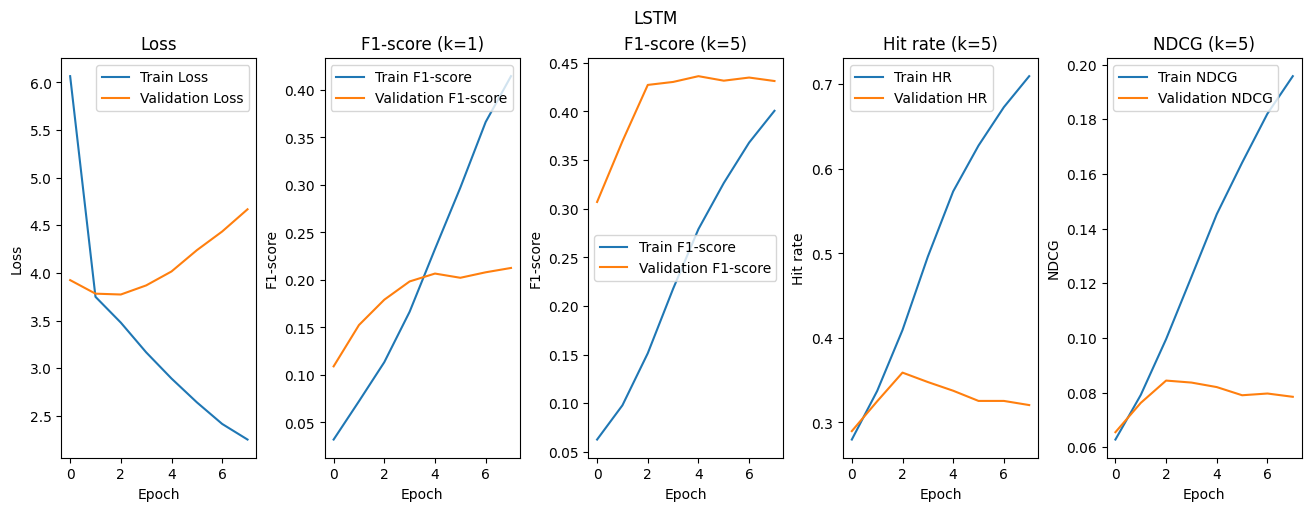

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1162 - f1_score: 0.1913 - f1_score_at_k: 0.4010 - hit_rate_at_k: 0.2810 - loss: 4.8207 - ndcg_at_k: 0.0676
Test loss: 4.7265
Test accuracy: 0.1469
Test F1@1: 0.2252
Test F1@5: 0.4245
Test HR@5: 0.3163
Test NDCG@5: 0.0793


In [32]:
parameters

{'user': 'users-10',
 'user_id': 'A1RT0UQRCB2765',
 'number_of_sequences_and_targets_before_removal': 23628,
 'number_of_sequences_and_targets_after_removal': 23200,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 22181,
 'num_unique_product_ids_in_targets': 112,
 'num_unique_product_ids_in_sequences': 15090,
 'number_of_sequences_and_targets_train': 17739,
 'number_of_sequences_and_targets_validation': 2216,
 'number_of_sequences_and_targets_test': 2226,
 'number_of_unique_products_in_targets_train': 110,
 'number_of_unique_products_in_targets_validation': 110,
 'number_of_unique_products_in_targets_test': 112,
 'model_lstm_test_loss': 4.726475715637207,
 'model_lstm_test_accuracy': 0.1469,
 'model_lstm_test_f1_score_k_1': 0.2252,
 'model_lstm_test_f1_score_k_5': 0.4245,
 'model_lstm_test_hr': 0.3163,
 'model_lstm_test_ndcg': 0.0793}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.0820 - f1_score: 0.0292 - f1_score_at_k: 0.0679 - hit_rate_at_k: 0.2838 - loss: 7.7464 - ndcg_at_k: 0.0616 - val_accuracy: 0.0970 - val_f1_score: 0.1025 - val_f1_score_at_k: 0.3077 - val_hit_rate_at_k: 0.2906 - val_loss: 3.8965 - val_ndcg_at_k: 0.0653
Epoch 2/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.0993 - f1_score: 0.0457 - f1_score_at_k: 0.0988 - hit_rate_at_k: 0.3342 - loss: 3.6874 - ndcg_at_k: 0.0736 - val_accuracy: 0.1209 - val_f1_score: 0.1465 - val_f1_score_at_k: 0.3803 - val_hit_rate_at_k: 0.3384 - val_loss: 3.7570 - val_ndcg_at_k: 0.0774
Epoch 3/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1627 - f1_score: 0.1147 - f1_score_at_k: 0.1666 - hit_rate_at_k: 0.4400 - loss: 3.3791 - ndcg_at_k: 0.1032 - val_accuracy: 0.1372 - val_f1_score: 0.1861 - val_f1_score_at_k: 0.4324 - val_hit_rate_at_k: 0.3585 - val_loss: 3.7660 - val_ndcg_at_k: 0.0852
Epoch 4/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 

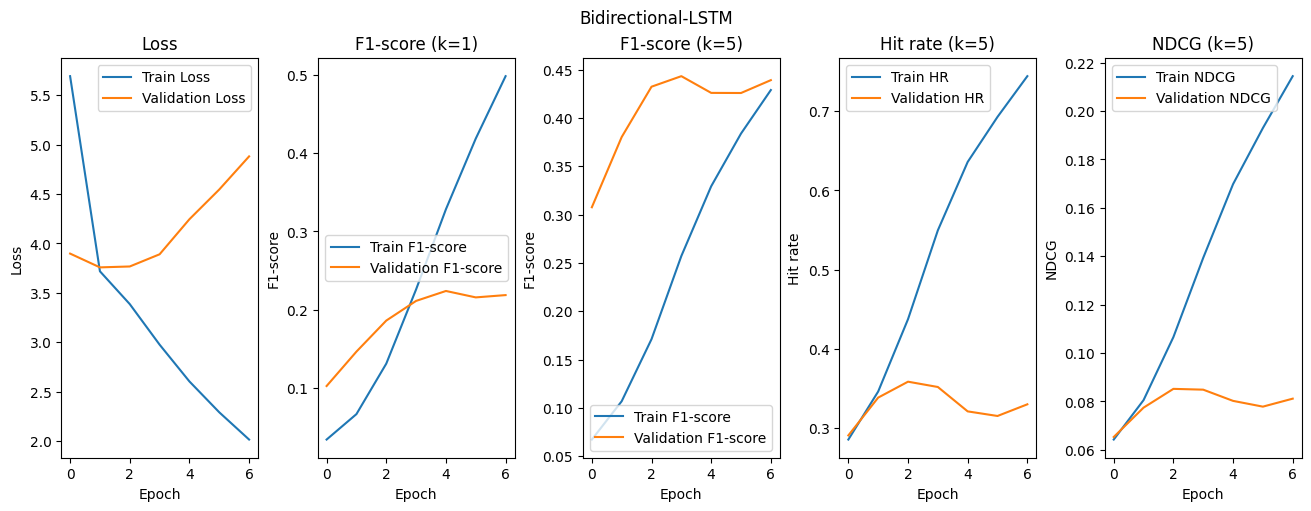

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.1238 - f1_score: 0.2031 - f1_score_at_k: 0.4150 - hit_rate_at_k: 0.2971 - loss: 4.8312 - ndcg_at_k: 0.0722
Test loss: 4.8446
Test accuracy: 0.1411
Test F1@1: 0.2175
Test F1@5: 0.4217
Test HR@5: 0.3126
Test NDCG@5: 0.0778


In [37]:
parameters

{'user': 'users-10',
 'user_id': 'A1RT0UQRCB2765',
 'number_of_sequences_and_targets_before_removal': 23628,
 'number_of_sequences_and_targets_after_removal': 23200,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 22181,
 'num_unique_product_ids_in_targets': 112,
 'num_unique_product_ids_in_sequences': 15090,
 'number_of_sequences_and_targets_train': 17739,
 'number_of_sequences_and_targets_validation': 2216,
 'number_of_sequences_and_targets_test': 2226,
 'number_of_unique_products_in_targets_train': 110,
 'number_of_unique_products_in_targets_validation': 110,
 'number_of_unique_products_in_targets_test': 112,
 'model_lstm_test_loss': 4.726475715637207,
 'model_lstm_test_accuracy': 0.1469,
 'model_lstm_test_f1_score_k_1': 0.2252,
 'model_lstm_test_f1_score_k_5': 0.4245,
 'model_lstm_test_hr': 0.3163,
 'model_lstm_test_ndcg': 0.0793,
 'model_bi_lstm_test_loss': 4.844636917114258,
 'model_bi_lstm_test_accuracy': 0.1411,
 'model_bi_lstm_test_f1_score_k_1': 0

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.0809 - f1_score: 0.0289 - f1_score_at_k: 0.0678 - hit_rate_at_k: 0.2819 - loss: 8.1205 - ndcg_at_k: 0.0614 - val_accuracy: 0.0975 - val_f1_score: 0.1058 - val_f1_score_at_k: 0.3023 - val_hit_rate_at_k: 0.2920 - val_loss: 3.8771 - val_ndcg_at_k: 0.0652
Epoch 2/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1028 - f1_score: 0.0503 - f1_score_at_k: 0.0952 - hit_rate_at_k: 0.3320 - loss: 3.7130 - ndcg_at_k: 0.0738 - val_accuracy: 0.1124 - val_f1_score: 0.1362 - val_f1_score_at_k: 0.3562 - val_hit_rate_at_k: 0.3277 - val_loss: 3.7760 - val_ndcg_at_k: 0.0747
Epoch 3/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1316 - f1_score: 0.0789 - f1_score_at_k: 0.1317 - hit_rate_at_k: 0.3823 - loss: 3.5407 - ndcg_at_k: 0.0877 - val_accuracy: 0.1327 - val_f1_score: 0.1772 - val_f1_score_at_k: 0.3858 - val_hit_rate_at_k: 0.3317 - val_loss: 3.7488 - val_ndcg_at_k: 0.0796
Epoch 4/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6

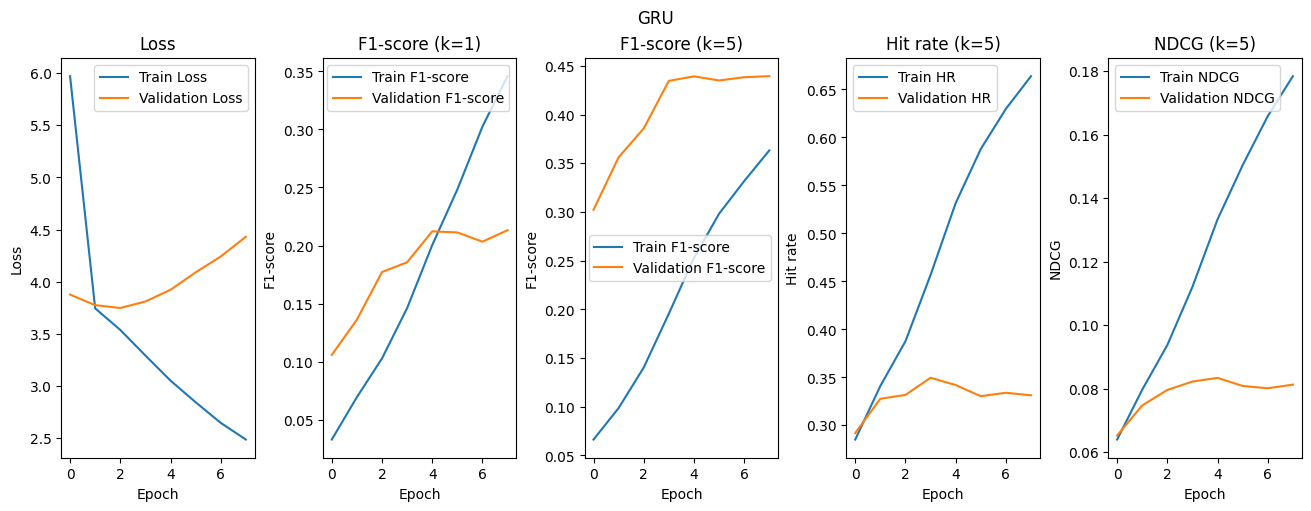

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1161 - f1_score: 0.1849 - f1_score_at_k: 0.4465 - hit_rate_at_k: 0.3260 - loss: 4.3886 - ndcg_at_k: 0.0749
Test loss: 4.4086
Test accuracy: 0.1424
Test F1@1: 0.2126
Test F1@5: 0.4403
Test HR@5: 0.3354
Test NDCG@5: 0.0817


In [42]:
parameters

{'user': 'users-10',
 'user_id': 'A1RT0UQRCB2765',
 'number_of_sequences_and_targets_before_removal': 23628,
 'number_of_sequences_and_targets_after_removal': 23200,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 22181,
 'num_unique_product_ids_in_targets': 112,
 'num_unique_product_ids_in_sequences': 15090,
 'number_of_sequences_and_targets_train': 17739,
 'number_of_sequences_and_targets_validation': 2216,
 'number_of_sequences_and_targets_test': 2226,
 'number_of_unique_products_in_targets_train': 110,
 'number_of_unique_products_in_targets_validation': 110,
 'number_of_unique_products_in_targets_test': 112,
 'model_lstm_test_loss': 4.726475715637207,
 'model_lstm_test_accuracy': 0.1469,
 'model_lstm_test_f1_score_k_1': 0.2252,
 'model_lstm_test_f1_score_k_5': 0.4245,
 'model_lstm_test_hr': 0.3163,
 'model_lstm_test_ndcg': 0.0793,
 'model_bi_lstm_test_loss': 4.844636917114258,
 'model_bi_lstm_test_accuracy': 0.1411,
 'model_bi_lstm_test_f1_score_k_1': 0

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.0452 - f1_score: 0.0326 - f1_score_at_k: 0.0755 - hit_rate_at_k: 0.1702 - loss: 9.8840 - ndcg_at_k: 0.0365 - val_accuracy: 0.0993 - val_f1_score: 0.1054 - val_f1_score_at_k: 0.3081 - val_hit_rate_at_k: 0.2937 - val_loss: 3.8780 - val_ndcg_at_k: 0.0667
Epoch 2/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0911 - f1_score: 0.0372 - f1_score_at_k: 0.0900 - hit_rate_at_k: 0.3046 - loss: 3.7851 - ndcg_at_k: 0.0669 - val_accuracy: 0.1060 - val_f1_score: 0.1190 - val_f1_score_at_k: 0.3260 - val_hit_rate_at_k: 0.3040 - val_loss: 3.8137 - val_ndcg_at_k: 0.0696
Epoch 3/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1003 - f1_score: 0.0530 - f1_score_at_k: 0.1010 - hit_rate_at_k: 0.3221 - loss: 3.7319 - ndcg_at_k: 0.0717 - val_accuracy: 0.1088 - val_f1_score: 0.1330 - val_f1_score_at_k: 0.3510 - val_hit_rate_at_k: 0.3179 - val_loss: 3.7759 - val_ndcg_at_k: 0.0728
Epoch 4/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7

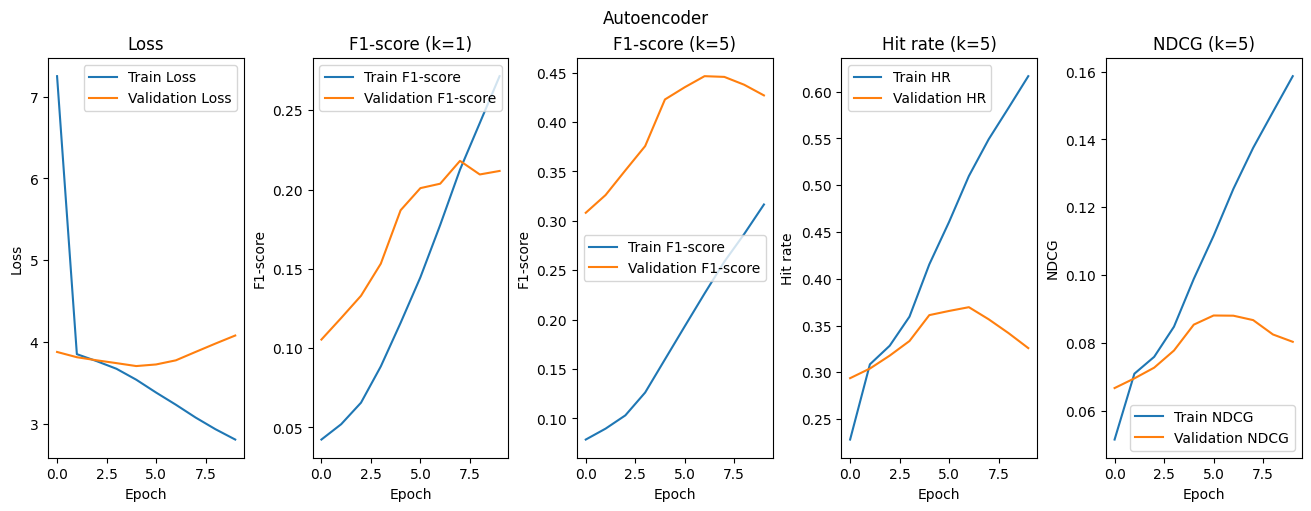

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1167 - f1_score: 0.1874 - f1_score_at_k: 0.4236 - hit_rate_at_k: 0.3151 - loss: 4.2105 - ndcg_at_k: 0.0740
Test loss: 4.0596
Test accuracy: 0.1433
Test F1@1: 0.2105
Test F1@5: 0.4379
Test HR@5: 0.3428
Test NDCG@5: 0.0833


In [47]:
parameters

{'user': 'users-10',
 'user_id': 'A1RT0UQRCB2765',
 'number_of_sequences_and_targets_before_removal': 23628,
 'number_of_sequences_and_targets_after_removal': 23200,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 22181,
 'num_unique_product_ids_in_targets': 112,
 'num_unique_product_ids_in_sequences': 15090,
 'number_of_sequences_and_targets_train': 17739,
 'number_of_sequences_and_targets_validation': 2216,
 'number_of_sequences_and_targets_test': 2226,
 'number_of_unique_products_in_targets_train': 110,
 'number_of_unique_products_in_targets_validation': 110,
 'number_of_unique_products_in_targets_test': 112,
 'model_lstm_test_loss': 4.726475715637207,
 'model_lstm_test_accuracy': 0.1469,
 'model_lstm_test_f1_score_k_1': 0.2252,
 'model_lstm_test_f1_score_k_5': 0.4245,
 'model_lstm_test_hr': 0.3163,
 'model_lstm_test_ndcg': 0.0793,
 'model_bi_lstm_test_loss': 4.844636917114258,
 'model_bi_lstm_test_accuracy': 0.1411,
 'model_bi_lstm_test_f1_score_k_1': 0

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A1RT0UQRCB2765', 'sequence': [124025, 7004], 'target': 30903}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 0.0
NDCG@10: 0.0
-------------
HT@20: 0.0
NDCG@20: 0.0
-------------
HT@50: 0.0
NDCG@50: 0.0
-------------
HT@100: 1.0
NDCG@100: 0.007252663839608431
-------------
HT@200: 1.0
NDCG@200: 0.004361561965197325
-------------
HT@300: 1.0
NDCG@300: 0.00320525118149817
-------------
HT@400: 1.0
NDCG@400: 0.0025647003203630447
-------------
HT@500: 1.0
NDCG@500: 0.0021523248869925737
-------------
